In [3]:
import pandas as pd
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.proportion import proportions_ztest
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus=False) # 음수표시
warnings.filterwarnings('ignore') # 경고메시지 출력 제외
import scipy.stats as stats

# 데이터 분할
from sklearn.model_selection import train_test_split

# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant

# 선형 모델
import statsmodels.formula.api as smf

# 평가 함수
from statsmodels.tools.eval_measures import rmse

# 결정계수 평가지표
from sklearn.metrics import r2_score

# 다중공선성
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 열연공장에서 수집한 가열로 데이터를 통하여 Slab의 장입온도에 영향을 미치는 주요인자를 확인하고,
# 모델 개발을 통하여 장입온도를 정확히 예측하여 가열로 원단위 저감 및 압연 생산성을 향상하고자 함
# (비슷한 온도인 slab만 넣어서 비용 절감)

In [4]:
df = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\새 폴더 (5)\\hotrolling.csv')

In [5]:
df.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean
0,571,30.6 ton,1570 mm,250 mm,9970 mm,14.3,8.0,255
1,351,23.65 ton,1020 mm,250 mm,11860 mm,10.3,13.4,340
2,460,34.63 ton,1500 mm,250 mm,11810 mm,14.6,7.5,253
3,488,28.94 ton,1570 mm,250 mm,9430 mm,14.4,7.8,252
4,335,34.81 ton,1500 mm,250 mm,11870 mm,14.7,7.2,253


## 결측치 확인
- SLABweight, SLABthick에 결측치 하나씩 있는것을 확인함

In [6]:
df.isnull().sum()

temp            0
SLABweight      1
SLABwide        0
SLABthick       1
SLABlong        0
RolljoblinLT    0
SHEARinLT       0
TSmean          0
dtype: int64

## 결측치가 있는 행 확인
- 관련 도메인 지식의 부족 -> 단순 결측치 제거

In [7]:
df[df.isnull().any(axis=1)]

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean
997,625,NaN,950 mm,250 mm,9090 mm,11.6,4.2,342
998,398,31.68 ton,1370 mm,NaN,11830 mm,14.5,11.5,328


In [8]:
df = df.dropna()

In [9]:
df.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean
0,571,30.6 ton,1570 mm,250 mm,9970 mm,14.3,8.0,255
1,351,23.65 ton,1020 mm,250 mm,11860 mm,10.3,13.4,340
2,460,34.63 ton,1500 mm,250 mm,11810 mm,14.6,7.5,253
3,488,28.94 ton,1570 mm,250 mm,9430 mm,14.4,7.8,252
4,335,34.81 ton,1500 mm,250 mm,11870 mm,14.7,7.2,253


### 분석을 위해 input요소들의 단위를 제거하여 float형으로 변환

In [10]:
df['SLABweight'] = df['SLABweight'].str.replace(' ton', '').astype(float)
df['SLABwide'] = df['SLABwide'].str.replace(' mm', '').astype(float)
df['SLABthick'] = df['SLABthick'].str.replace(' mm', '').astype(float)
df['SLABlong'] = df['SLABlong'].str.replace(' mm', '').astype(float)
df.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean
0,571,30.60,1570.0,250.0,9970.0,14.3,8.0,255
1,351,23.65,1020.0,250.0,11860.0,10.3,13.4,340
2,460,34.63,1500.0,250.0,11810.0,14.6,7.5,253
3,488,28.94,1570.0,250.0,9430.0,14.4,7.8,252
4,335,34.81,1500.0,250.0,11870.0,14.7,7.2,253


## 파생변수 필요성 검토

### SLABweight, SLABwide, RolljoblinLT, TSmean의 hist

Text(0.5, 1.0, 'TSmean')

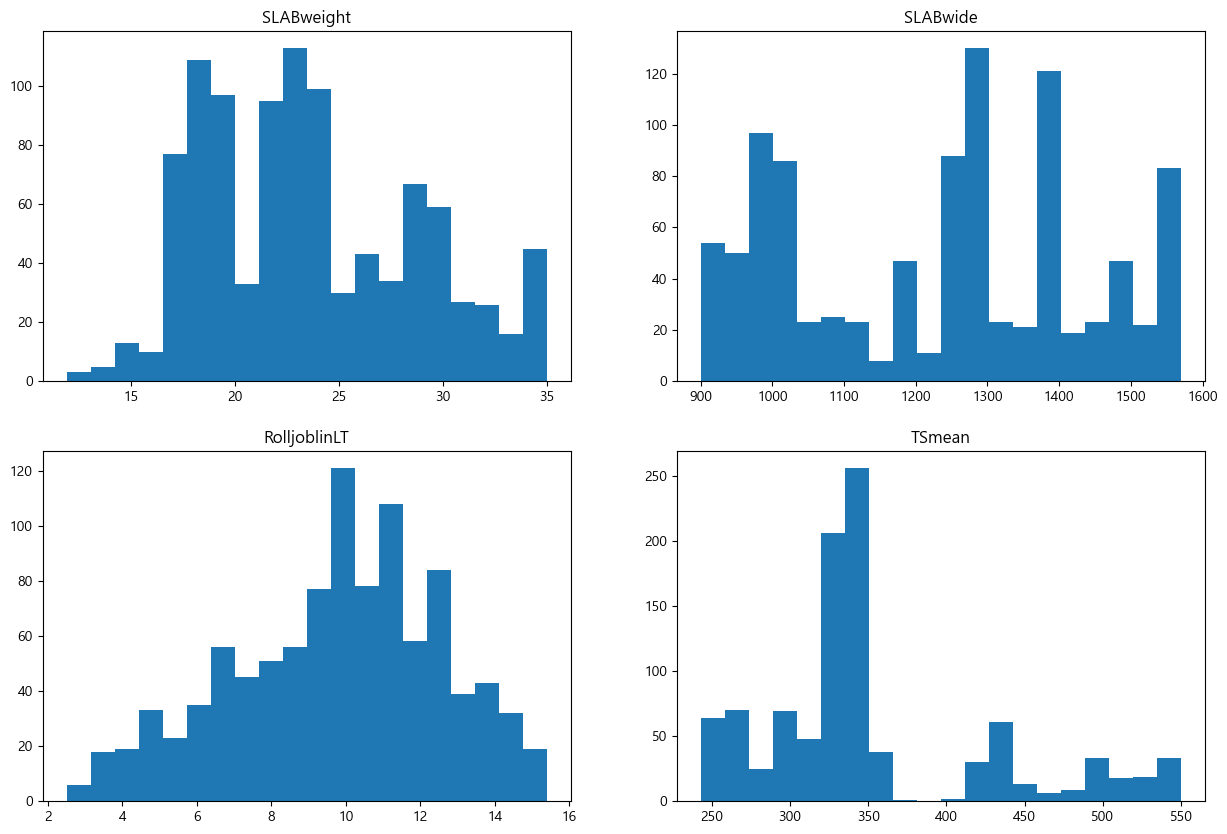

In [11]:
# 다음과 같은 4개의 변수들의 분포를 보고, 평균을 기준으로 두 개의 범주로 분할
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0,0].hist(x = 'SLABweight', data = df, bins = 20)
axs[0,0].set_title('SLABweight')

axs[0,1].hist(x = 'SLABwide', data = df, bins = 20)
axs[0,1].set_title('SLABwide')

axs[1,0].hist(x = 'RolljoblinLT', data = df, bins = 20)
axs[1,0].set_title('RolljoblinLT')

axs[1,1].hist(x = 'TSmean', data = df, bins = 20)
axs[1,1].set_title('TSmean')

In [12]:
# 평균을 기준으로 1, 0
mean_SLABweight = df['SLABweight'].mean()
mean_SLABwide = df['SLABwide'].mean()
mean_RolljoblinLT = df['RolljoblinLT'].mean()
mean_TSmean = df['TSmean'].mean()

df['SLABweight_category'] = df['SLABweight'].apply(lambda x: 1 if x >= mean_SLABweight else 0)
df['SLABwide_category'] = df['SLABwide'].apply(lambda x: 1 if x >= mean_SLABwide else 0)
df['RolljoblinLT_category'] = df['RolljoblinLT'].apply(lambda x: 1 if x >= mean_RolljoblinLT else 0)
df['TSmean_category'] = df['TSmean'].apply(lambda x: 1 if x >= mean_TSmean else 0)

### SLABthick의 hist

(array([ 13.,   0.,   0.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 941.]),
 array([244. , 244.3, 244.6, 244.9, 245.2, 245.5, 245.8, 246.1, 246.4,
        246.7, 247. , 247.3, 247.6, 247.9, 248.2, 248.5, 248.8, 249.1,
        249.4, 249.7, 250. ]),
 <BarContainer object of 20 artists>)

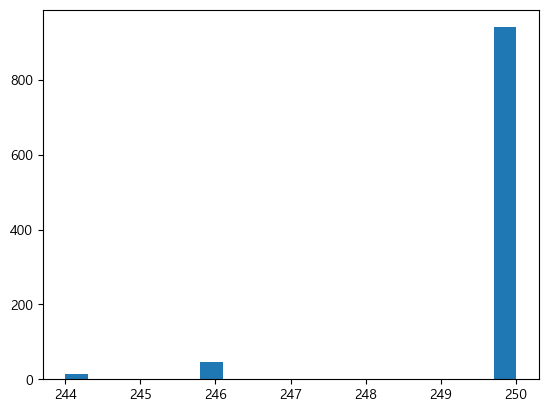

In [13]:
plt.hist(df['SLABthick'], bins = 20)

In [14]:
# 확인해보니 3개의 값들로만 이루어져있음
df['SLABthick'].value_counts()

SLABthick
250.0    941
246.0     47
244.0     13
Name: count, dtype: int64

In [15]:
# type을 다시확인해봄
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1002
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temp                   1001 non-null   int64  
 1   SLABweight             1001 non-null   float64
 2   SLABwide               1001 non-null   float64
 3   SLABthick              1001 non-null   float64
 4   SLABlong               1001 non-null   float64
 5   RolljoblinLT           1001 non-null   float64
 6   SHEARinLT              1001 non-null   float64
 7   TSmean                 1001 non-null   int64  
 8   SLABweight_category    1001 non-null   int64  
 9   SLABwide_category      1001 non-null   int64  
 10  RolljoblinLT_category  1001 non-null   int64  
 11  TSmean_category        1001 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 101.7 KB


In [16]:
# type을 바꾸어서 3개의 범주로 인식
df['SLABthick'] = df['SLABthick'].astype(str)

### SLABlong의 hist

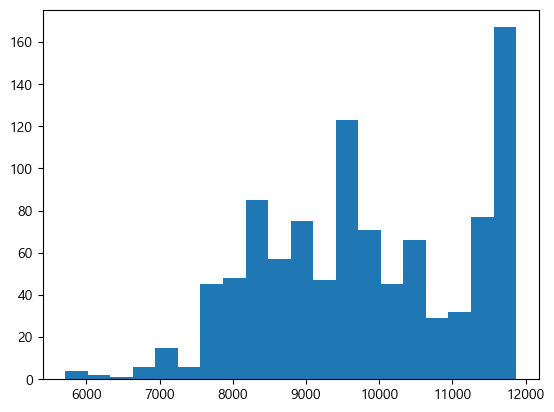

In [17]:
plt.hist(df['SLABlong'], bins = 20)
# 높은값들에 치우쳐져 있어서 75% 기준으로 0과1로 나눔

q75 = df['SLABlong'].quantile(0.75)

df['SLABlong_category'] = df['SLABlong'].apply(lambda x: 1 if x >= q75 else 0)

### SHEARinLT의 hist

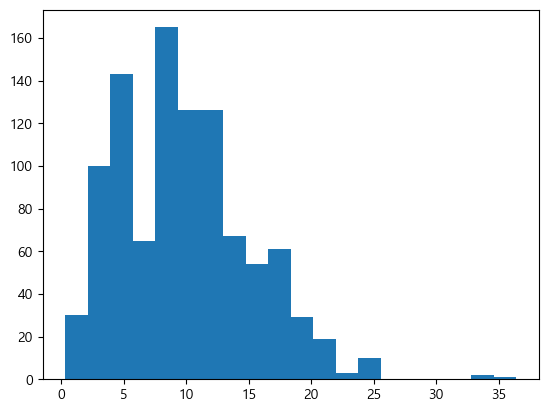

In [18]:
plt.hist(df['SHEARinLT'], bins = 20)
# 25%를 기준으로 0과1로 나눔

q25 = df['SHEARinLT'].quantile(0.25)

df['SHEARinLT_category'] = df['SHEARinLT'].apply(lambda x: 1 if x >= q25 else 0)

In [19]:
# 만들어진거 전부 확인
df.head()

,temp,SLABweight,SLABwide,SLABthick,SLABlong,RolljoblinLT,SHEARinLT,TSmean,SLABweight_category,SLABwide_category,RolljoblinLT_category,TSmean_category,SLABlong_category,SHEARinLT_category
0,571,30.60,1570.0,250.0,9970.0,14.3,8.0,255,1,1,1,0,0,1
1,351,23.65,1020.0,250.0,11860.0,10.3,13.4,340,1,0,1,0,1,1
2,460,34.63,1500.0,250.0,11810.0,14.6,7.5,253,1,1,1,0,1,1
3,488,28.94,1570.0,250.0,9430.0,14.4,7.8,252,1,1,1,0,0,1
4,335,34.81,1500.0,250.0,11870.0,14.7,7.2,253,1,1,1,0,1,1


## 관리도
- 점들이 중심선 주위에 랜덤하게 분포되어 있고 ucl, lcl 내에 존재- 
공정 변동이 안정적임

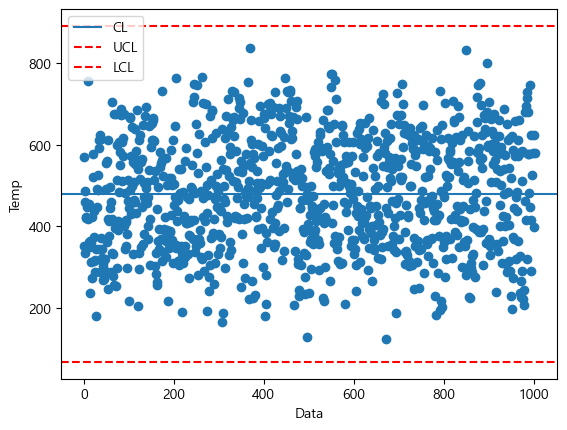

In [20]:
# individual, 군내 관리도
plt.scatter(df.index, df.temp, marker = 'o')
plt.xlabel('Data')
plt.ylabel('Temp')
plt.axhline(y = np.mean(df['temp']), linestyle = '-', label = 'CL')
plt.axhline(y = np.mean(df['temp']) + 3*np.std(df['temp']), linestyle = '--', color = 'red', label = 'UCL')
plt.axhline(y = np.mean(df['temp']) - 3*np.std(df['temp']), linestyle = 'dashed', color = 'red', label = 'LCL')
plt.legend()
plt.show()


### 이상징후 판단기준 8가지 중 어떤것에 의해 
### 0.59%의 ucl 범위를 벗어난 데이터가 있다

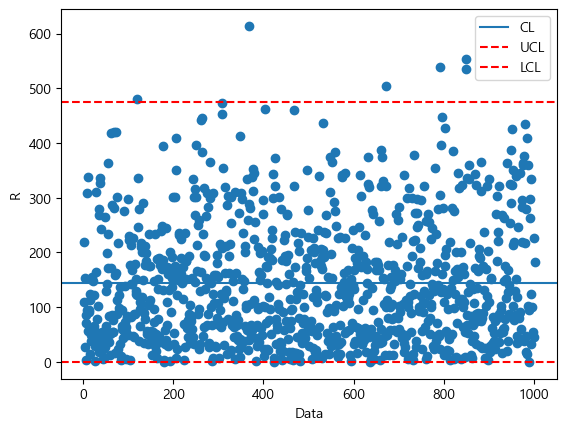

In [21]:
# moving range
df_mr = df[['temp']]
df_mr['R'] = df_mr['temp'].diff()
df_mr['R'] = np.abs(df_mr['R'])
df_mr = df_mr.dropna()
plt.scatter(df_mr.index, df_mr.R, marker = 'o')
plt.xlabel('Data')
plt.ylabel('R')
plt.axhline(y = np.mean(df_mr['R']), linestyle = '-', label = 'CL')
plt.axhline(y = np.mean(df_mr['R']) + 3*np.std(df_mr['R']), linestyle = '--', color = 'red', label = 'UCL')
if(np.mean(df_mr['R']) - 3*np.std(df_mr['R'])) < 0:
    plt.axhline(y = 0, linestyle = 'dashed', color = 'red', label = 'LCL')
else:
    plt.axhline(y = np.mean(df_mr['R']) - 3*np.std(df_mr['R']), linestyle = 'dashed', color = 'red', label = 'LCL')
plt.legend()
plt.show()

## 공정능력
- 공정등급 4등급- 
공정 능력이 대단히 부족하다.

In [25]:
# 공정능력지수 Cpk 계산, 규격하한(lsl) = 300, 규격상한(usl)은 없이
mean_temp = df['temp'].mean()
std_temp = df['temp'].std()

lsl = 300

cpk = (mean_temp - lsl) / (3 * std_temp)
cpk.round(3)

0.436

## 가설검정
- 앞서만든 파생변수들과 장입온도(temp)간의 가설검정
- 정규성검정: 현재 샘플크기가 30이상이므로, 중심극한정리에 의해 데이터 분포를 정규분포라고 가정한 뒤 t-test를 진행하였음

### 장입온도와 무게
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 등분산성 검정 -> 등분산성 만족
- 귀무가설: 무게를 나눈 기준에 대해(평균) 장입온도의 차이가 없다
- 대립가설: 무게를 나눈 기준에 대해 장입온도의 차이가 있다
- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- 무게를 나눈 기준에 대해 장입온도의 차이가 있다
- t 검정통계량 값이 3.377이므로 평균보다 낮은 무게에서 장입온도 평균이 더 높다고 볼 수 있다

In [27]:
stats.bartlett(df_weight0['temp'], df_weight1['temp'])

BartlettResult(statistic=0.9933644101772044, pvalue=0.3189214711957446)

In [26]:
df_weight0 = df[df['SLABweight_category'] == 0]
df_weight1 = df[df['SLABweight_category'] == 1]

t_result = stats.ttest_ind(df_weight0['temp'], df_weight1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(3.377, 0.001)

<Axes: xlabel='SLABweight_category', ylabel='temp'>

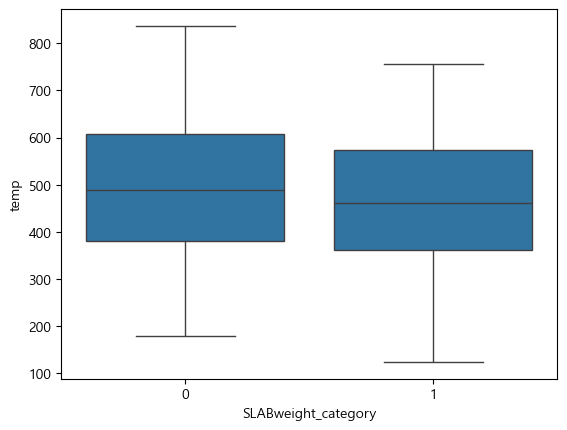

In [28]:
sns.boxplot(data = df, x = 'SLABweight_category', y = 'temp')

### 장입온도와 wide
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 등분산성검정 -> 등분산성을 만족하지 않음
- 귀무가설: wide를 나눈 기준에 대해(평균) 장입온도의 차이가 없다
- 대립가설: wide를 나눈 기준에 대해 장입온도의 차이가 있다

- p-value가 유의수준보다 높으므로 귀무가설을 기각할 수 없음
- wide를 나눈 기준에 대해 장입온도의 차이가 없다

In [29]:
df_wide0 = df[df['SLABwide_category'] == 0]
df_wide1 = df[df['SLABwide_category'] == 1]

t_result = stats.ttest_ind(df_wide0['temp'], df_wide1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p


(0.764, 0.445)

In [30]:
stats.bartlett(df_wide0['temp'], df_wide1['temp'])

BartlettResult(statistic=17.623132219607854, pvalue=2.6929279536086938e-05)

<Axes: xlabel='SLABwide_category', ylabel='temp'>

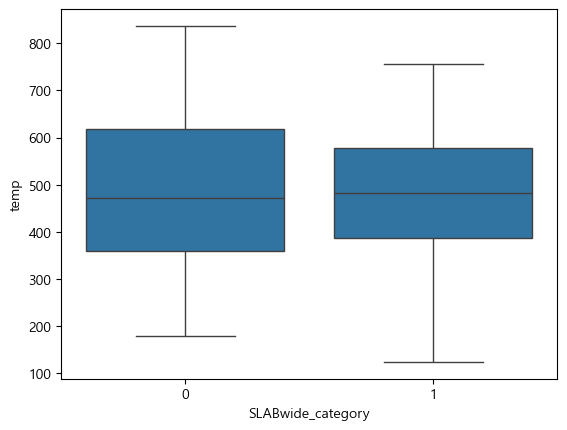

In [31]:
sns.boxplot(data = df, x = 'SLABwide_category', y = 'temp')

### 장입온도와 두께
- 3개의 범주형과 연속형의 가설검정으로 anova 진행
- 등분산성검정 -> 등분산성을 만족하지 않음
- 귀무가설: 두께를 나눈 기준에 대해(244, 246, 250)장입온도의 차이가 없다
- 대립가설: 적어도 한 집단의 두께에서 장입온도의 차이가 있다

- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- 적어도 한 집단의 두께에서 장입온도의 차이가 있다

In [32]:
df244 = df[df['SLABthick'] == '244.0']
df246 = df[df['SLABthick'] == '246.0']
df250 = df[df['SLABthick'] == '250.0']

f_result = stats.f_oneway(df244['temp'],df246['temp'],df250['temp'])
f, p = f_result.statistic.round(3), f_result.pvalue.round(3)
f, p


(57.821, 0.0)

In [33]:
stats.bartlett(df244['temp'], df246['temp'], df250['temp'])

BartlettResult(statistic=38.30109698579708, pvalue=4.819727272765523e-09)

## 244와 246 비교
- 귀무가설: 244와 246으로 나눈 temp의 평균에는 차이가 없다
- 대립가설: 244와 246으로 나눈 temp의 평균에는 차이가 있다
- p-value가 유의수준보다 높으므로 귀무가설을 기각할 수 없음
- 244와 246으로 나눈 temp의 평균에는 차이가 없다

In [34]:
t_result = stats.ttest_ind(df244['temp'], df246['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(0.9, 0.372)

<Axes: xlabel='SLABthick', ylabel='temp'>

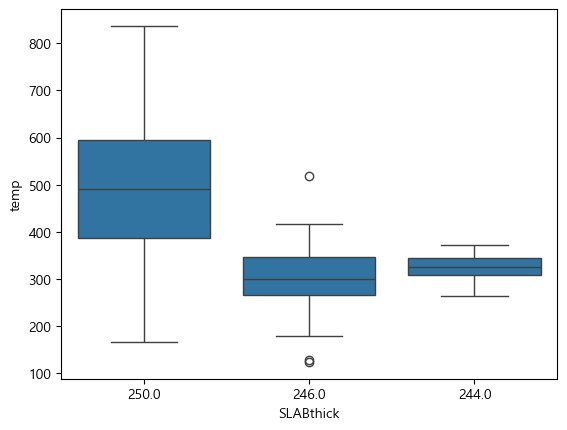

In [35]:
sns.boxplot(data = df, x = 'SLABthick', y = 'temp')

## 244와 250 비교
- 귀무가설: 244와 250으로 나눈 temp의 평균에는 차이가 없다
- 대립가설: 244와 250으로 나눈 temp의 평균에는 차이가 있다
- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- 244와 250으로 나눈 temp의 평균에는 차이가 있다
- t 검정통계량이 -4.616 으로 250의 temp평균이 더 높음을 알 수 있다

In [36]:
t_result = stats.ttest_ind(df244['temp'], df250['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(-4.616, 0.0)

## 246과 250 비교
- 귀무가설: 246와 250으로 나눈 temp의 평균에는 차이가 없다
- 대립가설: 246와 250으로 나눈 temp의 평균에는 차이가 있다
- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- 246와 250으로 나눈 temp의 평균에는 차이가 있다
- t 검정통계량이 -9.74 으로 250의 temp평균이 더 높음을 알 수 있다

In [37]:
t_result = stats.ttest_ind(df246['temp'], df250['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(-9.74, 0.0)

### 장입온도와 길이
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 등분산성검정 -> 등분산성을 만족
- 귀무가설: 길이를 나눈 기준에 대해(75%) 장입온도의 차이가 없다
- 대립가설: 길이를 나눈 기준에 대해 장입온도의 차이가 있다

- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- 길이를 나눈 기준에 대해 장입온도의 차이가 있다
- t 검정통계량 값이 6.256이므로  75%보다 짧은 길이에서 장입온도 평균이 더 높다고 볼 수 있다있다

In [38]:
df_long0 = df[df['SLABlong_category'] == 0]
df_long1 = df[df['SLABlong_category'] == 1]

t_result = stats.ttest_ind(df_long0['temp'], df_long1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(6.256, 0.0)

In [39]:
stats.bartlett(df_long0['temp'], df_long1['temp'])

BartlettResult(statistic=1.5244851900854746, pvalue=0.21694201004222455)

<Axes: xlabel='SLABlong_category', ylabel='temp'>

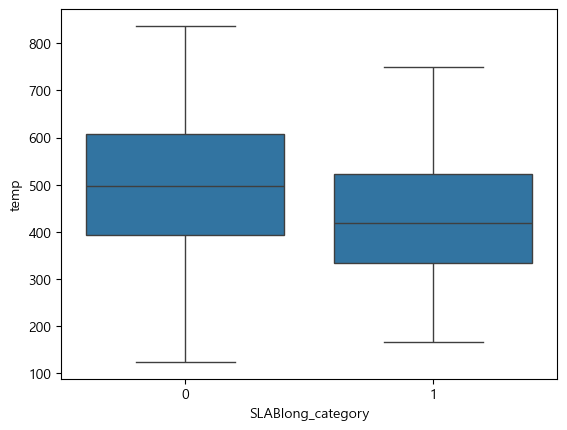

In [40]:
sns.boxplot(data = df, x = 'SLABlong_category', y = 'temp')

### 장입온도와 압연작업지시에서 열연 가열로 장입까지 소요되는 시간(RolljoblinLT)
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 등분산성검정 -> 등분산성을 만족하지 않음
- 귀무가설: RolljoblinLT 나눈 기준에 대해(평균) 장입온도의 차이가 없다
- 대립가설: RolljoblinLT 나눈 기준에 대해 장입온도의 차이가 있다

- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- RolljoblinLT를 나눈 기준에 대해 장입온도의 차이가 있다
- t 검정통계량 값이 4.075이므로 평균보다 짧은 가열로 장입까지 소요되는 시간에서 장입온도 평균이 더 높다고 볼 수 있다

In [41]:
df_RolljoblinLT0 = df[df['RolljoblinLT_category'] == 0]
df_RolljoblinLT1 = df[df['RolljoblinLT_category'] == 1]

t_result = stats.ttest_ind(df_RolljoblinLT0['temp'], df_RolljoblinLT1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(4.075, 0.0)

In [42]:
stats.bartlett(df_RolljoblinLT0['temp'], df_RolljoblinLT1['temp'])

BartlettResult(statistic=6.273621864577566, pvalue=0.01225483939342483)

<Axes: xlabel='RolljoblinLT_category', ylabel='temp'>

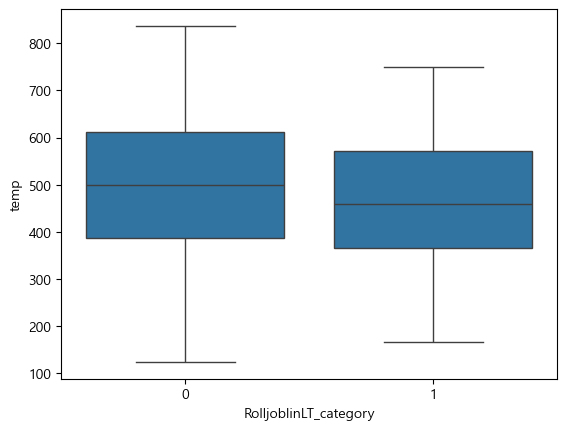

In [43]:
sns.boxplot(data = df, x = 'RolljoblinLT_category', y = 'temp')

### 장입온도와 전단공정~장입공정까지 소요되는 시간(SHEARinLT)
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 등분산성검정 -> 등분산성을 만족하지 않음
- 귀무가설: SHEARinLT 나눈 기준에 대해(25%) 장입온도의 차이가 없다
- 대립가설: SHEARinLT 나눈 기준에 대해 장입온도의 차이가 있다

- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- SHEARinLT를 나눈 기준에 대해 장입온도의 차이가 있다
- t 검정통계량 값이 24.897이므로 25%보다 작은 전단공정~장입공정까지 소요되는 시간에서 장입온도 평균이 더 높다고 볼 수 있다

In [44]:
df_SHEARinLT0 = df[df['SHEARinLT_category'] == 0]
df_SHEARinLT1 = df[df['SHEARinLT_category'] == 1]

t_result = stats.ttest_ind(df_SHEARinLT0['temp'], df_SHEARinLT1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(24.897, 0.0)

In [45]:
stats.bartlett(df_SHEARinLT0['temp'], df_SHEARinLT1['temp'])

BartlettResult(statistic=50.23289120075142, pvalue=1.3653995441462736e-12)

<Axes: xlabel='SHEARinLT_category', ylabel='temp'>

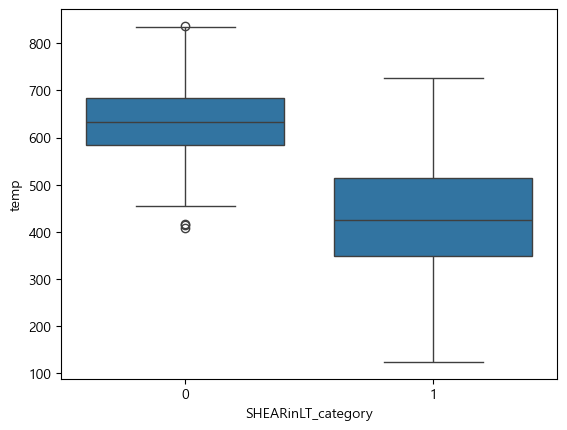

In [46]:
sns.boxplot(data = df, x = 'SHEARinLT_category', y = 'temp')

### 장입온도와 인장강도(TSmean)
- 범주형과 연속형의 가설검정으로 2 sample t test 진행
- 귀무가설: TSmean나눈 기준에 대해(평균) 장입온도의 차이가 없다
- 대립가설: TSmean나눈 기준에 대해 장입온도의 차이가 있다

- p-value가 유의수준보다 낮으므로 귀무가설을 기각
- TSmean를 나눈 기준에 대해 장입온도의 차이가 있다
- t 검정통계량 값이 -3.494이므로 평균보다 높은 인장강도에서 장입온도 평균이 더 높다고 볼 수 있다

In [47]:
df_TSmean0 = df[df['TSmean_category'] == 0]
df_TSmean1 = df[df['TSmean_category'] == 1]

t_result = stats.ttest_ind(df_TSmean0['temp'], df_TSmean1['temp'])
t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
t, p

(-3.493, 0.0)

<Axes: xlabel='TSmean_category', ylabel='temp'>

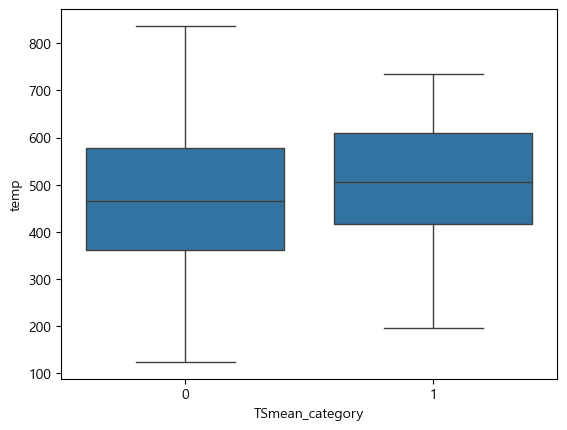

In [48]:
sns.boxplot(data = df, x = 'TSmean_category', y = 'temp')

## 상관분석
- heatmap으로 상관계수 확인
- temp와 SHEARinLT간에 강한 음의 상관관계가 있어 보임
- 상관분석 p값 확인해본 결과 wide 변수만 p값이 높게 나옴

<Axes: >

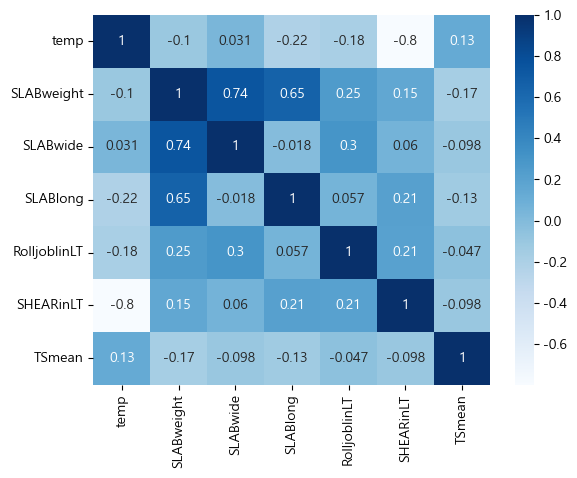

In [49]:
# heatmap으로 상관계수 확인
df = df[['temp', 'SLABweight', 'SLABwide', 'SLABthick', 'SLABlong','RolljoblinLT', 'SHEARinLT', 'TSmean']]

df_num = df.select_dtypes(exclude = 'object')
df_cor = df_num.corr(method = 'pearson')
sns.heatmap(df_cor, annot = True, cmap = 'Blues')

In [52]:
 df['SLABthick'] = df['SLABthick'].astype(float)

In [53]:
# wide변수만 상관관계가 유의하지 않다고 나옴
columns = [col for col in df.columns if col != 'temp']
print("Correlation Analysis")
for col in columns:
    corr, pval = stats.pearsonr(df[col], df['temp'])
    print(f"{col} - corr : {corr:0.3f}, p-value : {pval:0.7f}")

Correlation Analysis
SLABweight - corr : -0.103, p-value : 0.0011306
SLABwide - corr : 0.031, p-value : 0.3246250
SLABthick - corr : 0.313, p-value : 0.0000000
SLABlong - corr : -0.222, p-value : 0.0000000
RolljoblinLT - corr : -0.184, p-value : 0.0000000
SHEARinLT - corr : -0.797, p-value : 0.0000000
TSmean - corr : 0.134, p-value : 0.0000203


## 선형회귀분석
- SLABlong 의 p값이 0.056으로 유의하지 않은 변수 취급
- 제거하고 새로만들기

In [116]:
# 선형회귀분석
reg_model = smf.ols(formula = 'temp ~ SLABweight + SLABwide + SLABthick + SLABlong + RolljoblinLT + SHEARinLT + TSmean', data = df)

# 모델을 적합시키고 요약을 봄
reg_model.fit().summary()

# SLABlong 유의하지 않다고 봄

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     273.6
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          1.13e-226
Time:                        22:23:44   Log-Likelihood:                -5810.7
No. Observations:                1001   AIC:                         1.164e+04
Df Residuals:                     993   BIC:                         1.168e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2762.7044    696.238     -3.968      0.000   -4128.972   -1396.437
SLABweight     -11.9475      5.213     -2.292      0.022     -22.178      -1.717
SLABwide         0.3077      0.102      3.020      0.003       0.108       0.508
SLABthick       12.3909      2.641      4.692      0.000       7.208      17.573
SLABlong         0.0254      0.013      1.950      0.051      -0.000       0.051
RolljoblinLT    -3.0858      0.982     -3.143      0.002      -5.012      -1.159
SHEARinLT      -19.9141      0.546    -36.503      0.000     -20.985     -18.844
TSmean           0.0761      0.036      2.138      0.033       0.006       0.146
==============================================================================
Omnibus:                       13.740   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.195
Skew:                           0.138   Prob(JB):                     6.79e-05
Kurtosis:                       3.620   Cond. No.                     2.73e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
reg_model = smf.ols(formula = 'temp ~ SLABweight + SLABwide + SLABthick +  RolljoblinLT + SHEARinLT + TSmean', data = df)
reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     317.7
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          4.02e-227
Time:                        22:32:34   Log-Likelihood:                -5812.6
No. Observations:                1001   AIC:                         1.164e+04
Df Residuals:                     994   BIC:                         1.167e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2268.6284    649.414     -3.493      0.000   -3543.008    -994.248
SLABweight      -1.8884      0.755     -2.501      0.013      -3.370      -0.407
SLABwide         0.1126      0.019      5.810      0.000       0.075       0.151
SLABthick       11.4005      2.595      4.393      0.000       6.308      16.493
RolljoblinLT    -2.9395      0.980     -2.999      0.003      -4.863      -1.016
SHEARinLT      -19.6431      0.528    -37.182      0.000     -20.680     -18.606
TSmean           0.0810      0.036      2.276      0.023       0.011       0.151
==============================================================================
Omnibus:                       11.758   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.938
Skew:                           0.123   Prob(JB):                     0.000346
Kurtosis:                       3.567   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Omnibus 검정은 잔차의 정규성 -> p = 0.003으로 정규분포를 따른다고 할 수 없음
### Durbin-Watson 잔차의 독립성 -> 2에 가까울수록, 1.944
### Jarque-Bera 검정은 잔차의 정규성 -> p = 00003 으로 정규분포를 따른다고 할 수 없음

### vif확인

In [120]:
df_raw_x = df[['SLABweight', 'SLABwide', 'SLABthick', 'RolljoblinLT', 'SHEARinLT', 'TSmean']]
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
6,TSmean,1.067
4,RolljoblinLT,1.167
3,SLABthick,1.187
5,SHEARinLT,1.188
1,SLABweight,2.317
2,SLABwide,2.345
0,const,64738.627


### 잔차의 기본가정 검토(정규성, 등분산성, 독립성)
- 잔차가 y=0 선을 기준으로 random하게 산포되어 있으므로 등분산성 만족

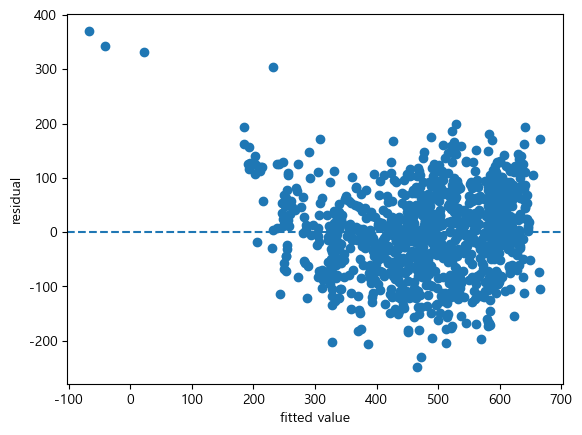

In [69]:
plt.scatter(reg_model.fit().fittedvalues, reg_model.fit().resid)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.axhline(y = 0, linestyle = '--')

### 잔차의 독립성을 만족함
### 잔차가 관리도의 관리기준을 초과하는 데이터가 거의 없고 경향성이 없으므로 독립성 만족

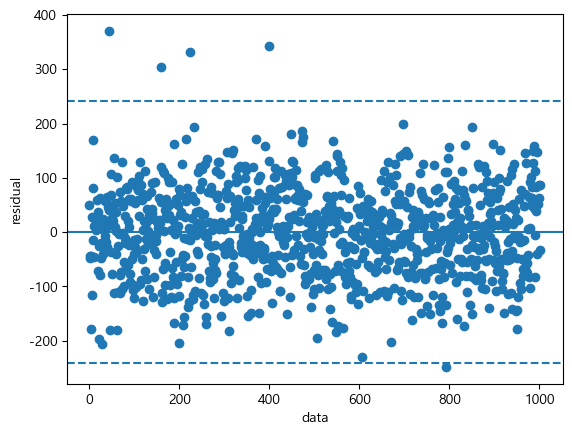

In [70]:
plt.scatter(df.index, reg_model.fit().resid, marker = 'o')
plt.xlabel('data')
plt.ylabel('residual')
plt.axhline(y = 0, linestyle = '-')
plt.axhline(y = 3*np.std(reg_model.fit().resid), linestyle = '--')
plt.axhline(y = -3*np.std(reg_model.fit().resid), linestyle = '--')

### qq plot으로 정규성을 한번 더 봄

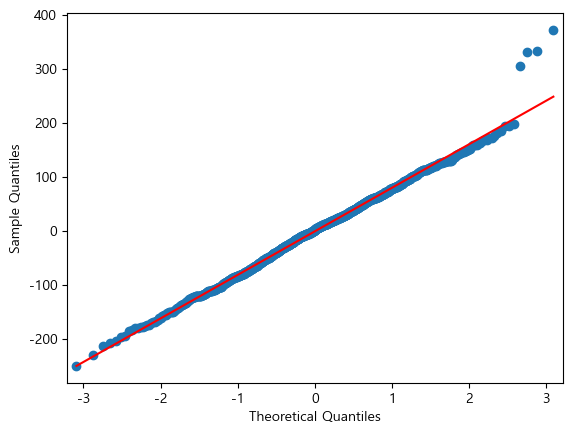

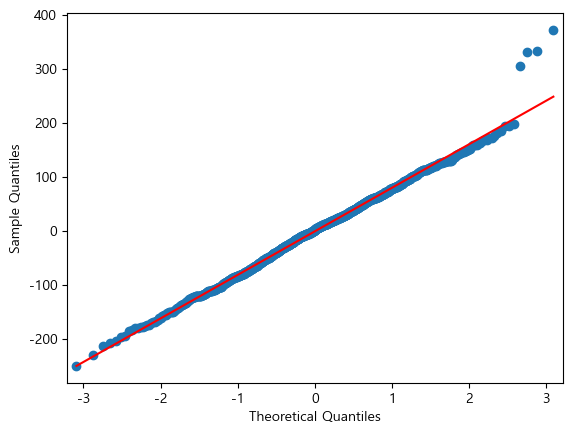

In [90]:
qqplot(reg_model.fit().resid, line = 'q')

# 최종 모델 회귀식
## temp = -2268.6284 -1.8884*SLABweight +0.1126*SLABwide +11.4005 *SLABthick  -2.9395* RolljoblinLT  -19.6431*SHEARinLT + 0.0810 * TSmean
## SLABweight
## SLABwide
## SLABthick
## RolljoblinLT
## **SHEARinLT 전단공정~장입공정까지 소요되는 시간**
## TSmean